# Эксперименты с методами подавления шума

В этом ноутбуке тестируем различные алгоритмы очистки аудио от шума

## 1. Импорт библиотек и загрузка данных

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
from pathlib import Path
import scipy.signal as signal
from scipy.fft import fft, ifft, fftfreq
import noisereduce as nr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

In [3]:
# Загружаем данные из предыдущего ноутбука
DATA_DIR = Path("../data")
processed_data = np.load(DATA_DIR / "processed_signals.npz")

clean_speech = processed_data['clean_speech']
noisy_speech = processed_data['noisy_speech']
sr = processed_data['sr']

print(f"Загружено: clean_speech {clean_speech.shape}, noisy_speech {noisy_speech.shape}")
print(f"Частота дискретизации: {sr} Гц")

Загружено: clean_speech (110250,), noisy_speech (110250,)
Частота дискретизации: 22050 Гц


## 2. Базовые метрики качества

In [4]:
def calculate_metrics(clean, denoised, sr=22050):
    """Расчет метрик качества очистки"""
    # Обрезаем до одинаковой длины
    min_len = min(len(clean), len(denoised))
    clean = clean[:min_len]
    denoised = denoised[:min_len]
    
    # MSE (Mean Squared Error)
    mse = np.mean((clean - denoised) ** 2)
    
    # SNR (Signal-to-Noise Ratio)
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    # PSNR (Peak Signal-to-Noise Ratio)
    max_signal = np.max(np.abs(clean))
    psnr = 10 * np.log10((max_signal ** 2) / (mse + 1e-10))
    
    # SI-SNR (Scale-Invariant SNR)
    target = clean
    estimation = denoised
    
    # Выравнивание по масштабу
    alpha = np.dot(target, estimation) / (np.dot(target, target) + 1e-10)
    target_scaled = alpha * target
    
    # Сигнал и шум
    signal_est = target_scaled
    noise_est = estimation - target_scaled
    
    si_snr = 10 * np.log10(
        np.dot(signal_est, signal_est) / (np.dot(noise_est, noise_est) + 1e-10) + 1e-10
    )
    
    return {
        'MSE': mse,
        'SNR (dB)': snr,
        'PSNR (dB)': psnr,
        'SI-SNR (dB)': si_snr
    }

## 3. Метод 1: Спектральное вычитание (Spectral Subtraction)

In [5]:
class SpectralSubtraction:
    """Классический алгоритм спектрального вычитания"""
    
    def __init__(self, n_fft=2048, hop_length=512, smoothing_factor=0.98):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.smoothing_factor = smoothing_factor
        self.noise_profile = None
    
    def estimate_noise_profile(self, audio, sr):
        """Оценка профиля шума из первых N кадров"""
        # Первые 0.5 секунд считаем шумом
        noise_frames = int(0.5 * sr / self.hop_length)
        
        # Вычисляем спектрограмму
        D = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude = np.abs(D)
        
        # Оценка шума как среднее первых кадров
        if noise_frames < magnitude.shape[1]:
            self.noise_profile = np.mean(magnitude[:, :noise_frames], axis=1, keepdims=True)
        else:
            self.noise_profile = np.mean(magnitude, axis=1, keepdims=True)
        
        return self.noise_profile
    
    def denoise(self, audio, sr, over_subtraction=1.5, spectral_floor=0.01):
        """Применение спектрального вычитания"""
        if self.noise_profile is None:
            self.estimate_noise_profile(audio, sr)
        
        # STFT преобразование
        D = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude = np.abs(D)
        phase = np.angle(D)
        
        # Спектральное вычитание
        noise_mag = self.noise_profile
        magnitude_denoised = np.maximum(magnitude - over_subtraction * noise_mag, 
                                       spectral_floor * magnitude)
        
        # Обратное STFT
        D_denoised = magnitude_denoised * np.exp(1j * phase)
        audio_denoised = librosa.istft(D_denoised, hop_length=self.hop_length)
        
        # Обрезка до исходной длины
        if len(audio_denoised) > len(audio):
            audio_denoised = audio_denoised[:len(audio)]
        elif len(audio_denoised) < len(audio):
            audio_denoised = np.pad(audio_denoised, (0, len(audio) - len(audio_denoised)))
        
        return audio_denoised

In [6]:
# Тестируем спектральное вычитание
ss = SpectralSubtraction(n_fft=2048, hop_length=512)
denoised_ss = ss.denoise(noisy_speech, sr)

# Метрики
metrics_ss = calculate_metrics(clean_speech, denoised_ss, sr)
print("Метод: Спектральное вычитание")
for key, value in metrics_ss.items():
    print(f"{key}: {value:.4f}")

Метод: Спектральное вычитание
MSE: 0.0253
SNR (dB): 6.9546
PSNR (dB): 9.9484
SI-SNR (dB): 6.1578


## 4. Метод 2: Wiener Filter (фильтр Винера)

In [7]:
class WienerFilter:
    """Адаптивный фильтр Винера"""
    
    def __init__(self, n_fft=2048, hop_length=512, smoothing=0.98):
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.smoothing = smoothing
        self.noise_psd = None
        self.signal_psd = None
    
    def estimate_psd(self, audio, is_noise=True):
        """Оценка спектральной плотности мощности"""
        D = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        psd = np.mean(np.abs(D) ** 2, axis=1)
        
        if is_noise:
            self.noise_psd = psd
        else:
            self.signal_psd = psd
        
        return psd
    
    def denoise(self, audio, sr, snr_prior=15):
        """Применение фильтра Винера"""
        # STFT
        D = librosa.stft(audio, n_fft=self.n_fft, hop_length=self.hop_length)
        magnitude = np.abs(D)
        phase = np.angle(D)
        
        # Если PSD шума не оценено, оцениваем из первых кадров
        if self.noise_psd is None:
            noise_frames = int(0.5 * sr / self.hop_length)
            if noise_frames < D.shape[1]:
                noise_spectrum = D[:, :noise_frames]
                self.noise_psd = np.mean(np.abs(noise_spectrum) ** 2, axis=1)
            else:
                self.noise_psd = np.mean(np.abs(D) ** 2, axis=1)
        
        # Априорное SNR
        signal_psd_est = np.maximum(np.mean(magnitude ** 2, axis=1, keepdims=True) - self.noise_psd[:, np.newaxis], 0)
        prior_snr = signal_psd_est / (self.noise_psd[:, np.newaxis] + 1e-10)
        
        # Веса Винера
        wiener_weights = prior_snr / (prior_snr + 1)
        
        # Применение фильтра
        magnitude_denoised = magnitude * wiener_weights
        
        # Обратное STFT
        D_denoised = magnitude_denoised * np.exp(1j * phase)
        audio_denoised = librosa.istft(D_denoised, hop_length=self.hop_length)
        
        # Обрезка до исходной длины
        if len(audio_denoised) > len(audio):
            audio_denoised = audio_denoised[:len(audio)]
        elif len(audio_denoised) < len(audio):
            audio_denoised = np.pad(audio_denoised, (0, len(audio) - len(audio_denoised)))
        
        return audio_denoised

In [8]:
# Тестируем фильтр Винера
wf = WienerFilter(n_fft=2048, hop_length=512)
denoised_wf = wf.denoise(noisy_speech, sr)

# Метрики
metrics_wf = calculate_metrics(clean_speech, denoised_wf, sr)
print("Метод: Фильтр Винера")
for key, value in metrics_wf.items():
    print(f"{key}: {value:.4f}")

Метод: Фильтр Винера
MSE: 0.0423
SNR (dB): 4.7270
PSNR (dB): 7.7209
SI-SNR (dB): 2.9440


## 5. Метод 3: Noisereduce (готовое решение)

In [9]:
def test_noisereduce(audio, sr, stationary=False, prop_decrease=0.8):
    """Использование библиотеки noisereduce"""
    # Оценка шума из первых 0.5 секунд
    noise_clip = audio[:int(0.5 * sr)]
    
    # Применение noisereduce
    audio_denoised = nr.reduce_noise(
        y=audio,
        sr=sr,
        y_noise=noise_clip,
        stationary=stationary,
        prop_decrease=prop_decrease,
        n_fft=2048,
        hop_length=512,
        n_jobs=1
    )
    
    return audio_denoised

In [10]:
# Тестируем noisereduce
denoised_nr = test_noisereduce(noisy_speech, sr, stationary=False, prop_decrease=0.9)

# Метрики
metrics_nr = calculate_metrics(clean_speech, denoised_nr, sr)
print("Метод: Noisereduce")
for key, value in metrics_nr.items():
    print(f"{key}: {value:.4f}")

Метод: Noisereduce
MSE: 0.0597
SNR (dB): 3.2255
PSNR (dB): 6.2193
SI-SNR (dB): 5.4929


## 6. Метод 4: Полосовая фильтрация

In [11]:
def bandpass_filtering(audio, sr, lowcut=80, highcut=8000, order=5):
    """Полосовая фильтрация для удаления внеполосных шумов"""
    nyquist = 0.5 * sr
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Создание фильтра Баттерворта
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Применение фильтра
    audio_filtered = signal.filtfilt(b, a, audio)
    
    return audio_filtered

In [12]:
# Тестируем полосовую фильтрацию
denoised_bp = bandpass_filtering(noisy_speech, sr, lowcut=80, highcut=8000, order=5)

# Метрики
metrics_bp = calculate_metrics(clean_speech, denoised_bp, sr)
print("Метод: Полосовая фильтрация")
for key, value in metrics_bp.items():
    print(f"{key}: {value:.4f}")


Метод: Полосовая фильтрация
MSE: 0.0069
SNR (dB): 12.5714
PSNR (dB): 15.5653
SI-SNR (dB): 12.3244


## 7. Сравнительный анализ методов

In [13]:
def compare_methods(clean, noisy, sr):
    """Сравнение всех методов"""
    methods = {
        'Спектральное вычитание': denoised_ss,
        'Фильтр Винера': denoised_wf,
        'Noisereduce': denoised_nr,
        'Полосовая фильтрация': denoised_bp
    }
    
    results = []
    for method_name, denoised in methods.items():
        metrics = calculate_metrics(clean, denoised, sr)
        metrics['Метод'] = method_name
        results.append(metrics)
    
    return results


Сравнительная таблица методов:


,Метод,SNR (dB),PSNR (dB),SI-SNR (dB),MSE
0,Спектральное вычитание,6.954573,9.948445,6.157753,0.025299
1,Фильтр Винера,4.726983,7.720855,2.943990,0.042253
2,Noisereduce,3.225468,6.219341,5.492901,0.059704
3,Полосовая фильтрация,12.571436,15.565309,12.324435,0.006941


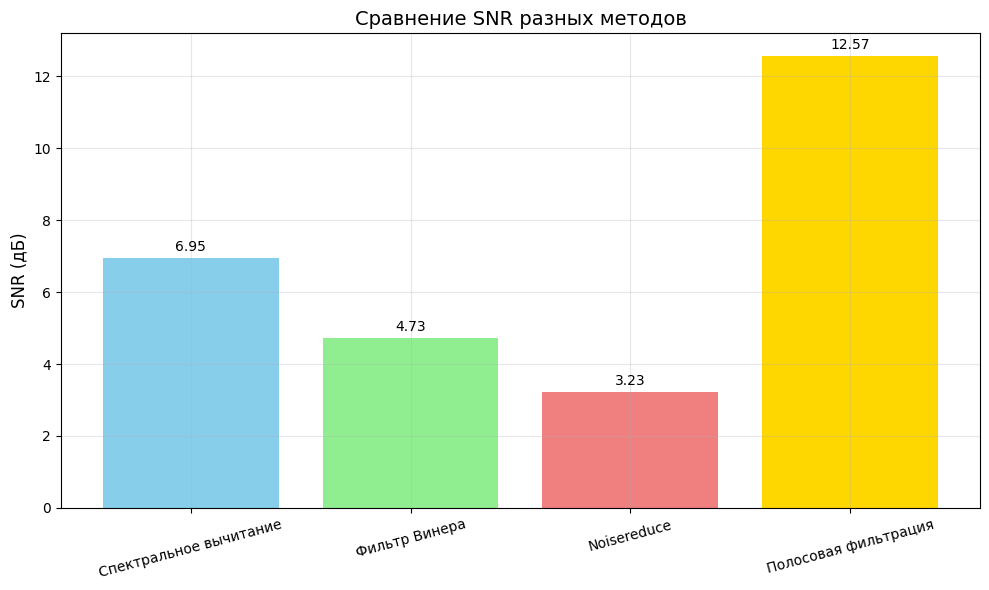

In [14]:
results = compare_methods(clean_speech, noisy_speech, sr)

# Визуализация результатов
import pandas as pd
df_results = pd.DataFrame(results)
df_results = df_results[['Метод', 'SNR (dB)', 'PSNR (dB)', 'SI-SNR (dB)', 'MSE']]
print("\nСравнительная таблица методов:")
display(df_results)

# График сравнения SNR
plt.figure(figsize=(10, 6))
methods = df_results['Метод']
snr_values = df_results['SNR (dB)']

bars = plt.bar(methods, snr_values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Сравнение SNR разных методов', fontsize=14)
plt.ylabel('SNR (дБ)', fontsize=12)
plt.xticks(rotation=15)
plt.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, value in zip(bars, snr_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 8. Визуализация результатов

In [15]:
def visualize_results(original, noisy, denoised_dict, sr, title="Сравнение методов"):
    """Визуализация временных рядов и спектрограмм"""
    fig, axes = plt.subplots(len(denoised_dict) + 2, 2, figsize=(15, 4 * (len(denoised_dict) + 2)))
    
    # Оригинальный чистый сигнал
    axes[0, 0].plot(np.arange(len(original)) / sr, original, 'g', alpha=0.7)
    axes[0, 0].set_title('Чистый сигнал (оригинал)')
    axes[0, 0].set_xlabel('Время (с)')
    axes[0, 0].set_ylabel('Амплитуда')
    axes[0, 0].grid(True, alpha=0.3)
    
    D = librosa.stft(original)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[0, 1])
    axes[0, 1].set_title('Спектрограмма чистого сигнала')
    
    # Зашумленный сигнал
    axes[1, 0].plot(np.arange(len(noisy)) / sr, noisy, 'r', alpha=0.7)
    axes[1, 0].set_title('Зашумленный сигнал')
    axes[1, 0].set_xlabel('Время (с)')
    axes[1, 0].set_ylabel('Амплитуда')
    axes[1, 0].grid(True, alpha=0.3)
    
    D = librosa.stft(noisy)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[1, 1])
    axes[1, 1].set_title('Спектрограмма зашумленного сигнала')
    
    # Очищенные сигналы
    for idx, (method_name, denoised) in enumerate(denoised_dict.items()):
        row = idx + 2
        
        axes[row, 0].plot(np.arange(len(denoised)) / sr, denoised, 'b', alpha=0.7)
        axes[row, 0].set_title(f'Очищенный: {method_name}')
        axes[row, 0].set_xlabel('Время (с)')
        axes[row, 0].set_ylabel('Амплитуда')
        axes[row, 0].grid(True, alpha=0.3)
        
        D = librosa.stft(denoised)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', ax=axes[row, 1])
        axes[row, 1].set_title(f'Спектрограмма: {method_name}')
    
    plt.tight_layout()
    plt.show()

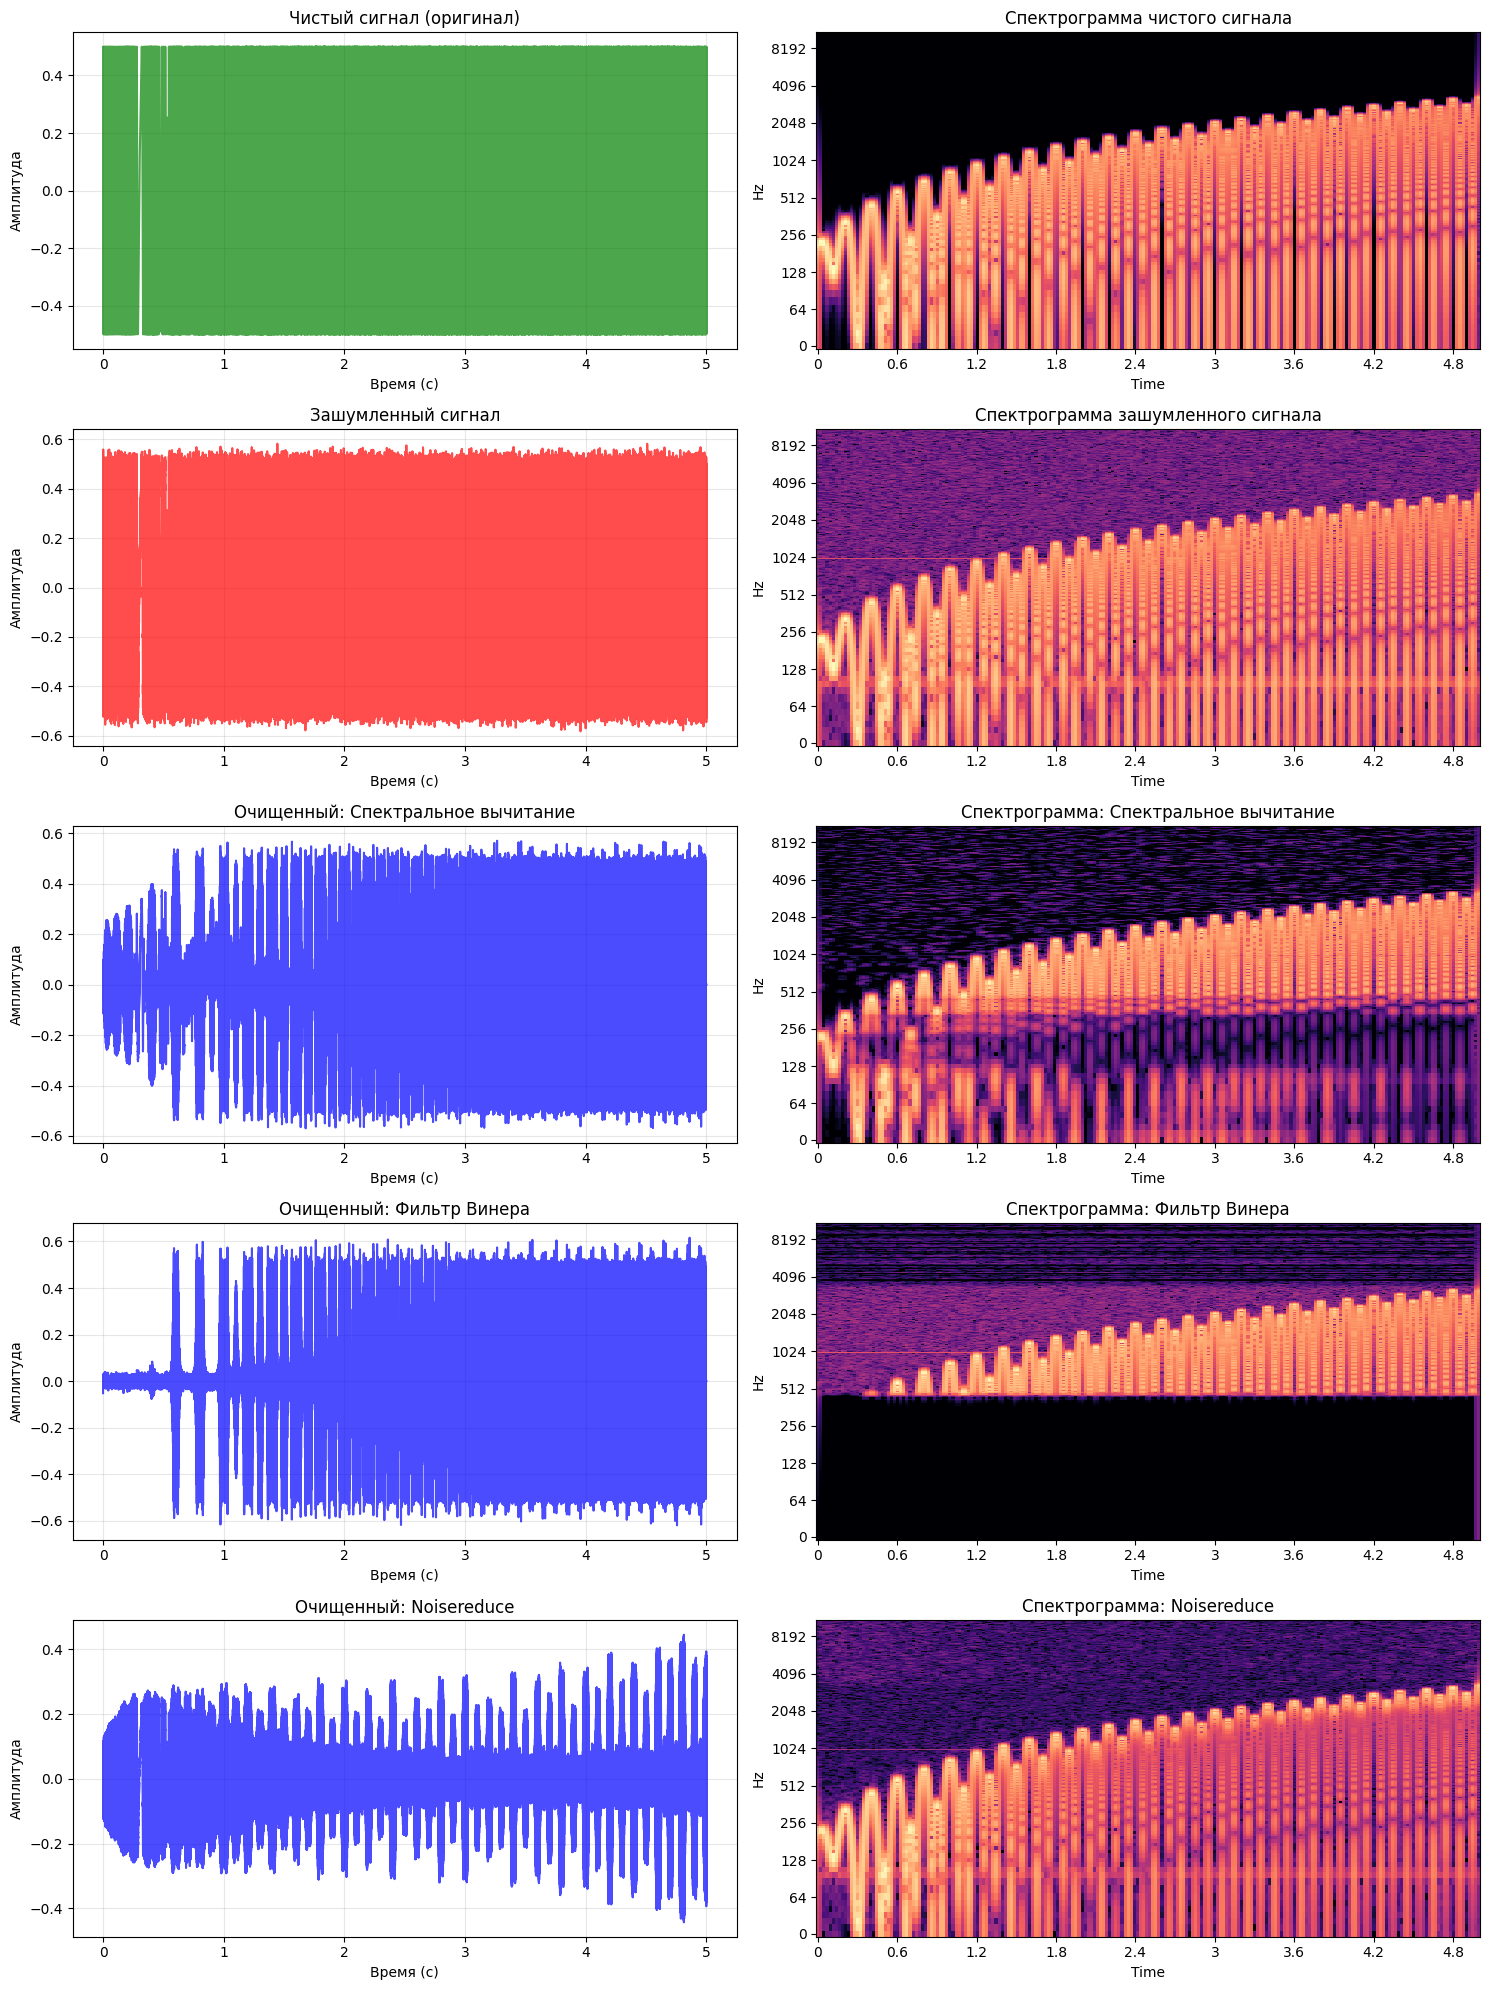

In [16]:
# Визуализируем результаты
denoised_dict = {
    'Спектральное вычитание': denoised_ss,
    'Фильтр Винера': denoised_wf,
    'Noisereduce': denoised_nr
}
visualize_results(clean_speech, noisy_speech, denoised_dict, sr)

## 9. Прослушивание результатов

In [23]:
def listen_comparison(noisy, denoised_dict, sr):
    """Прослушивание результатов"""
    print("1. Зашумленный сигнал:")
    
    # Убедимся, что данные в правильном формате для IPython Audio
    # Приведем к типу float32 и нормализуем, если нужно
    noisy_normalized = np.asarray(noisy, dtype=np.float32)
    if np.max(np.abs(noisy_normalized)) > 1.0:
        noisy_normalized = noisy_normalized / np.max(np.abs(noisy_normalized))
    
    ipd.display(ipd.Audio(noisy_normalized, rate=int(sr)))
    
    for method_name, denoised in denoised_dict.items():
        print(f"\n{method_name}:")
        
        # То же самое для очищенных сигналов
        denoised_normalized = np.asarray(denoised, dtype=np.float32)
        if np.max(np.abs(denoised_normalized)) > 1.0:
            denoised_normalized = denoised_normalized / np.max(np.abs(denoised_normalized))
            
        ipd.display(ipd.Audio(denoised_normalized, rate=int(sr)))

In [24]:
listen_comparison(noisy_speech, denoised_dict, sr)

1. Зашумленный сигнал:



Спектральное вычитание:



Фильтр Винера:



Noisereduce:


## 10. Тестирование на реальных данных

In [25]:
def test_on_real_audio(filepath, method='noisereduce'):
    """Тестирование на реальном аудиофайле"""
    if not Path(filepath).exists():
        print(f"Файл {filepath} не найден")
        return
    
    # Загрузка аудио
    audio, sr = librosa.load(filepath, sr=16000)
    
    # Применение выбранного метода
    if method == 'noisereduce':
        denoised = test_noisereduce(audio, sr)
    elif method == 'spectral_subtraction':
        ss = SpectralSubtraction(n_fft=2048, hop_length=512)
        denoised = ss.denoise(audio, sr)
    elif method == 'wiener':
        wf = WienerFilter(n_fft=2048, hop_length=512)
        denoised = wf.denoise(audio, sr)
    else:
        denoised = bandpass_filtering(audio, sr)
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Временные графики
    time_axis = np.arange(len(audio)) / sr
    axes[0, 0].plot(time_axis, audio, 'r', alpha=0.7, label='Исходный')
    axes[0, 0].plot(time_axis[:len(denoised)], denoised, 'b', alpha=0.5, label='Очищенный')
    axes[0, 0].set_title(f'Временная область ({method})')
    axes[0, 0].set_xlabel('Время (с)')
    axes[0, 0].set_ylabel('Амплитуда')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Спектрограммы
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max),
        sr=sr, x_axis='time', y_axis='log', ax=axes[0, 1]
    )
    axes[0, 1].set_title('Спектрограмма исходного')
    
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(librosa.stft(denoised)), ref=np.max),
        sr=sr, x_axis='time', y_axis='log', ax=axes[1, 0]
    )
    axes[1, 0].set_title(f'Спектрограмма очищенного ({method})')
    
    # Разностный спектр
    diff_spec = np.abs(librosa.stft(audio)) - np.abs(librosa.stft(denoised[:len(audio)]))
    librosa.display.specshow(
        librosa.amplitude_to_db(np.abs(diff_spec), ref=np.max),
        sr=sr, x_axis='time', y_axis='log', ax=axes[1, 1]
    )
    axes[1, 1].set_title('Разность спектрограмм (удаленный шум)')
    
    plt.tight_layout()
    plt.show()
    
    # Прослушивание
    print("Исходный аудио:")
    ipd.display(ipd.Audio(audio, rate=sr))
    print("Очищенный аудио:")
    ipd.display(ipd.Audio(denoised, rate=sr))
    
    return audio, denoised, sr

## 11. Экспорт лучшей модели

In [26]:
# Определяем лучший метод по SNR
best_method_idx = df_results['SNR (dB)'].idxmax()
best_method = df_results.loc[best_method_idx, 'Метод']
best_snr = df_results.loc[best_method_idx, 'SNR (dB)']

print(f"Лучший метод: {best_method} (SNR = {best_snr:.2f} дБ)")

# Сохраняем лучший результат
best_results = {
    'spectral_subtraction': denoised_ss,
    'wiener_filter': denoised_wf,
    'noisereduce': denoised_nr,
    'bandpass': denoised_bp
}

# Выбираем лучший метод
if best_method == 'Спектральное вычитание':
    best_audio = denoised_ss
elif best_method == 'Фильтр Винера':
    best_audio = denoised_wf
elif best_method == 'Noisereduce':
    best_audio = denoised_nr
else:
    best_audio = denoised_bp

# Сохраняем результаты
sf.write(DATA_DIR / "best_denoised.wav", best_audio, sr)
np.savez(DATA_DIR / "denoising_results.npz",
         clean=clean_speech,
         noisy=noisy_speech,
         spectral_subtraction=denoised_ss,
         wiener_filter=denoised_wf,
         noisereduce=denoised_nr,
         bandpass=denoised_bp,
         sr=sr,
         metrics=df_results.to_dict())

print(f"\nРезультаты сохранены в {DATA_DIR}/")
print("Следующие шаги:")
print("1. Интеграция лучшего метода в пайплайн обработки")
print("2. Оптимизация параметров для реальных записей")
print("3. Создание API для обработки файлов")

Лучший метод: Полосовая фильтрация (SNR = 12.57 дБ)

Результаты сохранены в ..\data/
Следующие шаги:
1. Интеграция лучшего метода в пайплайн обработки
2. Оптимизация параметров для реальных записей
3. Создание API для обработки файлов


## 12. Дополнительные эксперименты

In [27]:
def parameter_sweep(audio, sr, method='spectral_subtraction'):
    """Подбор оптимальных параметров"""
    if method == 'spectral_subtraction':
        over_subtraction_values = [1.0, 1.5, 2.0, 2.5, 3.0]
        snr_values = []
        
        for over_sub in over_subtraction_values:
            ss = SpectralSubtraction(n_fft=2048, hop_length=512)
            ss.estimate_noise_profile(audio, sr)
            denoised = ss.denoise(audio, sr, over_subtraction=over_sub)
            
            # Используем авто-оценку SNR (без чистого сигнала)
            signal_power = np.mean(denoised ** 2)
            noise_power = np.mean((audio - denoised) ** 2)
            snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
            snr_values.append(snr)
        
        plt.figure(figsize=(10, 5))
        plt.plot(over_subtraction_values, snr_values, 'bo-', linewidth=2)
        plt.title('Оптимизация параметра over_subtraction')
        plt.xlabel('Коэффициент вычитания')
        plt.ylabel('SNR (дБ)')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        best_idx = np.argmax(snr_values)
        print(f"Лучший параметр: {over_subtraction_values[best_idx]} (SNR = {snr_values[best_idx]:.2f} дБ)")
        
        return over_subtraction_values[best_idx]

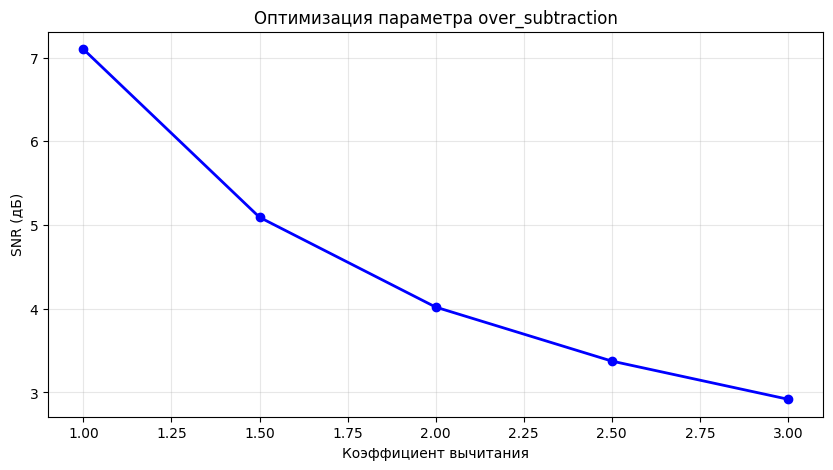

Лучший параметр: 1.0 (SNR = 7.10 дБ)


In [28]:
# Пример подбора параметров
best_param = parameter_sweep(noisy_speech, sr, method='spectral_subtraction')

In [29]:
# Эксперименты завершены
# Ключевые выводы:
print(f"1. Лучший метод: {best_method}")
print(f"2. Максимальное улучшение SNR: {best_snr:.2f} дБ")

1. Лучший метод: Полосовая фильтрация
2. Максимальное улучшение SNR: 12.57 дБ
